In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons

import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-31ff8ikh
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-31ff8ikh
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440312 sha256=cb3cc11a4ba6932bd52eb2ba262c81d75a84efa014ccdf8cde52840234f38891
  Stored in directory: /tmp/pip-ephem-wheel-cache-tvso7ct4/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Suc

2025-12-05 11:58:34.356218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764935914.561983      33 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764935914.619333      33 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
working_dir = '/kaggle/working'
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/.virtual_documents


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            img = img / 255.0
            mask = mask / 255.0

            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            label = mel_label[index]

            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [ ]:
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Train_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2017-melanoma/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 635/635 [02:03<00:00,  5.14it/s]



Đã đọc thành công 635 ảnh
Shape của images: (635, 256, 256, 3)
Shape của masks: (635, 256, 256, 1)
Shape của labels: (635,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Test_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 272/272 [00:39<00:00,  6.84it/s]


Đã đọc thành công 272 ảnh
Shape của images: (272, 256, 256, 3)
Shape của masks: (272, 256, 256, 1)
Shape của labels: (272,)


In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[1] // x.shape[1], dims[2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size=256, num_classes=1):
    inputs = Input(shape=(image_size, image_size, 1))
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    base_model = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=x
    )
    x = base_model.get_layer("conv4_block6_2_relu").output 
    x = DilatedSpatialPyramidPooling(x)

    input_b = base_model.get_layer("conv2_block3_2_relu").output 
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    input_a = layers.UpSampling2D(
        size=(input_b.shape[1] // x.shape[1], input_b.shape[2] // x.shape[2]),
        interpolation="bilinear",
    )(x)


    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x, num_filters=256)
    x = convolution_block(x, num_filters=256)

    
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=model_output, name="DeepLabV3Plus")
    return model

IMAGE_SIZE = 256
NUM_CLASSES = 1   
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()


I0000 00:00:1764936090.067458      33 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "DeepLabV3Plus"

In [9]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [10]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

        img_clahe = clahe.apply(gray) 
        grays.append(img_clahe)

    return np.array(grays)

train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [ ]:
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

IMAGE_SIZE = 256
NUM_CLASSES = 1   
deeplab = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

deeplab.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)
model_checkpoint_dir = 'model'
checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)
start_time = time.time()


history = deeplab.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

print("deeplab output shape:", deeplab.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1764936144.790940     189 service.cc:148] XLA service 0x7db72c0e30b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764936144.791724     189 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1764936146.524073     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1764936146.524186     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
I0000 00:00:1764936148.758286     189 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-05 12:02:37.695426: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,304,64,64]{3,2,1,0}, f32[256,304,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8145 - jaccard_coefficient: 0.4697 - loss: 0.3835

W0000 00:00:1764936202.668508     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1764936202.668618     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
E0000 00:00:1764936211.093116     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764936211.367560     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764936212.818834     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764936213.084654     189 gpu_timer.cc:82] Delay kernel timed out: measured time h

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8174 - jaccard_coefficient: 0.4758 - loss: 0.3777   
Epoch 1: loss improved from inf to 0.26779, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8199 - jaccard_coefficient: 0.4814 - loss: 0.3725 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9026 - jaccard_coefficient: 0.6823 - loss: 0.1894
Epoch 2: loss improved from 0.26779 to 0.18359, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step - accuracy: 0.9031 - jaccard_coefficient: 0.6827 - loss: 0.1891 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9335 - jaccard_coefficient: 0.7487 - loss: 0.1439
Epoch 3: loss improved from 0.18359 to 0.15309, saving model to model/gray2750.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 653ms/step - accuracy: 0.9333 - jaccard_coefficient: 0.7481 - loss: 0.1443 - learning_rate: 0.0010
Epoch 4

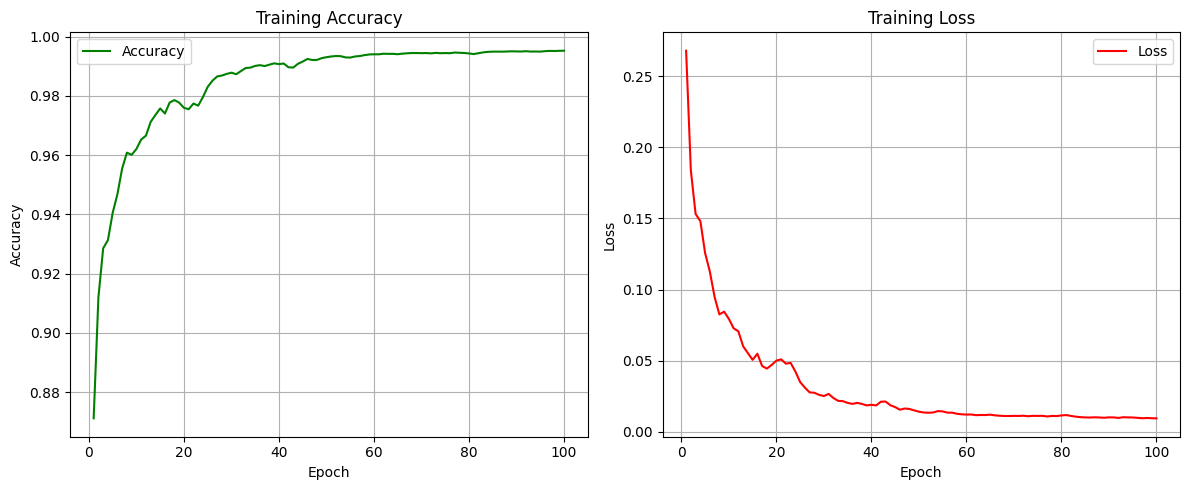

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Gray_2750_acc_loss.png', dpi=300)
plt.show()


In [ ]:
def apply_morphology(mask, kernel_size=3, iterations=1):

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  

    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  

print("🔍 Đánh giá không hậu xử lý...")
results = deeplab.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

print("\n🔧 Đánh giá sau Morphology...")
predictions1 = deeplab.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...


W0000 00:00:1764937503.323589     186 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1764937503.323717     186 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9309 - jaccard_coefficient: 0.7386 - loss: 0.1534

W0000 00:00:1764937507.420396     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1764937507.420560     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9291 - jaccard_coefficient: 0.7285 - loss: 0.1612 
Không hậu xử lý - Dice Loss: 0.1924, Accuracy: 92.19%, Jaccard: 68.79%

🔧 Đánh giá sau Morphology...
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

W0000 00:00:1764937523.246269     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1764937523.246380     189 assert_op.cc:38] Ignoring Assert operator DeepLabV3Plus_1/lambda_1_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 845ms/step


100%|██████████| 272/272 [00:00<00:00, 1514.78it/s]


Sau Morphology - Dice Loss: 0.1730, Accuracy: 92.30%, Jaccard: 70.51%


In [17]:
deeplab.save('/kaggle/working/model/deeplabV3_907_model.h5')
deeplab.save('/kaggle/working/model/deeplabV3_907_model.keras')